In [27]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, blend_models,tune_model,predict_model,get_config, finalize_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.family'] = 'Gulim'

In [2]:
from workalendar.asia import SouthKorea
import pendulum

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## 전처리
- 일자에서 월과 일을 분리
- 요일을 레이블 인코딩화(EDA로 요일의 중요도 순 파악)
- 월 별, 일 별 중식 석식 수요 차이 파악

In [4]:
train['월'] = pd.DatetimeIndex(train['일자']).month.astype(str)
test['월'] = pd.DatetimeIndex(test['일자']).month.astype(str)
train['주'] = pd.DatetimeIndex(train['일자']).week.astype(str)
test['주'] = pd.DatetimeIndex(test['일자']).week.astype(str)
train['일'] = pd.DatetimeIndex(train['일자']).day.astype(str)
test['일'] = pd.DatetimeIndex(test['일자']).day.astype(str)

train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

## 공휴일 변수 생성

In [5]:
def is_holiday(date):
    holidays = list(map(str, pd.Series(np.array(SouthKorea().holidays(int(date[:4])))[:, 0])))
    
    yesterday = str(np.datetime64(date) - 1)
    tomorrow = str(np.datetime64(date) + 1)

    if tomorrow in holidays and yesterday in holidays:
        return'S'
    if tomorrow in holidays:
        return 'T'
    elif yesterday in holidays:
        return 'Y'
    else : 
        return 'N'

def week_of_month(x):
    dt = pendulum.parse(x)
    
    wom = dt.week_of_month
    if wom < 0:
        wom += 52
    return str(wom)
    

df = pd.concat([train[['본사정원수', '일자']], test[['본사정원수', '일자']]])
df['년월'] = df['일자'].apply(lambda x : x[:7])
df = df[['년월', '본사정원수']].groupby(by=['년월'], as_index=False).mean()

def member_change(date):
    this_month = date[:7]
    last_month = str(np.datetime64(this_month) - 1)
    
    this_month_member = int(df[df['년월'] == this_month]['본사정원수'])
    last_month_member = int(df[df['년월'] == last_month]['본사정원수'])
    
    
    return  this_month_member - last_month_member

train['공휴일전후'] = train['일자'].apply(is_holiday)
test['공휴일전후'] = test['일자'].apply(is_holiday)

train['몇주차'] = train['일자'].apply(week_of_month)
test['몇주차'] = test['일자'].apply(week_of_month)

train = train[train['일자'] > '2016-03']
train['인원변화'] = train['일자'].apply(member_change)
test['인원변화'] = test['일자'].apply(member_change)

## 최종 데이터 셋 구축

In [6]:
train.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계', '월', '주', '일',
       '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '공휴일전후', '몇주차', '인원변화'],
      dtype='object')

In [7]:
lunch_train = train.drop(columns=['본사정원수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','일자','석식계', '조식메뉴', '중식메뉴', '석식메뉴'])
lunch_test = test.drop(columns=['본사정원수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','일자',  '조식메뉴', '중식메뉴', '석식메뉴'])


dinner_train = train.drop(columns=['본사정원수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','일자', '중식계', '조식메뉴', '중식메뉴', '석식메뉴'])
dinner_test = test.drop(columns=['본사정원수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','일자', '조식메뉴', '중식메뉴', '석식메뉴'])

In [8]:
print(lunch_train.shape)
print(lunch_test.shape)

(1187, 15)
(50, 14)


In [9]:
print(dinner_train.shape)
print(dinner_test.shape)

(1187, 15)
(50, 14)


In [10]:
dinner_train.columns

Index(['요일', '본사휴가자수', '본사출장자수', '석식계', '월', '주', '일', '출근', '휴가비율', '출장비율',
       '야근비율', '재택비율', '공휴일전후', '몇주차', '인원변화'],
      dtype='object')

# 중식 예측모델

In [11]:
y_lunch = np.array(lunch_train['중식계'])
y_lunch = y_lunch.reshape(-1)
lunch_train.drop(columns=['중식계'], inplace=True)

y_dinner = np.array(dinner_train['석식계'])
y_dinner = y_dinner.reshape(-1)
dinner_train.drop(columns=['석식계'], inplace=True)

In [12]:
cat_features = [f for f in lunch_train.columns if lunch_train[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(lunch_train, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['요일', '월', '주', '일', '공휴일전후', '몇주차']
[ 0  3  4  5 11 12]


In [13]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

n_fold = 8

kfold = KFold(n_splits=n_fold, shuffle=False)
# for each fold

lunch_models = [CatBoostRegressor(n_estimators = 3000, learning_rate = 0.01, loss_function='MAE') for _ in range(n_fold)]
lunch_preds = []
lunch_trues = []

for idx, (tr_idx, val_idx) in enumerate(kfold.split(lunch_train, y_lunch)):
    X_tr, X_val = lunch_train.iloc[tr_idx], lunch_train.iloc[val_idx]
    y_tr, y_val = y_lunch[tr_idx], y_lunch[val_idx]

    temp_model = lunch_models[idx]
    temp_model.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_val, y_val)],
                   early_stopping_rounds= 500,
                   cat_features=cat_features,
                   verbose=400)
    
    lunch_models[idx] = temp_model
    
    pred = temp_model.predict(X_val)
    true = y_val
    lunch_preds.extend(pred)
    lunch_trues.extend(true)

0:	learn: 170.9283998	test: 170.9185250	test1: 140.3802004	best: 140.3802004 (0)	total: 153ms	remaining: 7m 39s
400:	learn: 64.2251641	test: 65.4156728	test1: 66.4415805	best: 66.4271195 (394)	total: 6.61s	remaining: 42.9s
800:	learn: 53.2053019	test: 57.5650923	test1: 67.1230960	best: 66.4120082 (405)	total: 12.9s	remaining: 35.5s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 66.41200821
bestIteration = 405

Shrink model to first 406 iterations.
0:	learn: 167.0498352	test: 167.0411551	test1: 169.3008715	best: 169.3008715 (0)	total: 17.9ms	remaining: 53.7s
400:	learn: 65.1539986	test: 65.8404852	test1: 75.7648236	best: 75.7648236 (400)	total: 6.41s	remaining: 41.5s
800:	learn: 54.0647641	test: 57.3916182	test1: 69.5471939	best: 69.5212755 (797)	total: 12.7s	remaining: 34.9s
1200:	learn: 47.4867334	test: 52.9922104	test1: 67.8804323	best: 67.8629163 (1196)	total: 19s	remaining: 28.5s
1600:	learn: 42.6568690	test: 50.2131840	test1: 67.1088776	best: 67.1026908 (1588)	

### 테스트 데이터 예측

In [14]:
lunch = np.array([0]*50).astype(np.float64)

for model in lunch_models:
    lunch += model.predict(lunch_test)
    
lunch /= n_fold

lunch_preds = np.array(lunch_preds)
lunch_trues = np.array(lunch_trues)

abs(lunch_trues-lunch_preds).mean()

73.32027400441419

# 석식 예측모델

In [15]:
dinner_models = [CatBoostRegressor(n_estimators = 3000, learning_rate = 0.01, loss_function='MAE') for _ in range(n_fold)]
dinner_preds = []
dinner_trues = []

for idx, (tr_idx, val_idx) in enumerate(kfold.split(dinner_train, y_dinner)):
    X_tr, X_val = dinner_train.iloc[tr_idx, :-1], dinner_train.iloc[val_idx, :-1]
    y_tr, y_val = y_dinner[tr_idx], y_dinner[val_idx]

    temp_model = dinner_models[idx]
    temp_model.fit(X_tr, y_tr,
                   eval_set=[(X_tr, y_tr), (X_val, y_val)],
                   early_stopping_rounds= 400,
                   cat_features=cat_features,
                   verbose=400)
    
    dinner_models[idx] = temp_model
    
    pred = temp_model.predict(X_val)
    true = y_val
    dinner_preds.extend(pred)
    dinner_trues.extend(true)

0:	learn: 101.2100472	test: 101.2100472	test1: 78.3517440	best: 78.3517440 (0)	total: 20.5ms	remaining: 1m 1s
400:	learn: 55.3424580	test: 56.6481056	test1: 69.0899874	best: 69.0686236 (399)	total: 6.03s	remaining: 39.1s
800:	learn: 47.2447129	test: 50.5077191	test1: 68.5574055	best: 67.8384449 (719)	total: 12.3s	remaining: 33.7s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 67.83844492
bestIteration = 719

Shrink model to first 720 iterations.
0:	learn: 99.1308853	test: 99.1346137	test1: 90.1131534	best: 90.1131534 (0)	total: 13.8ms	remaining: 41.4s
400:	learn: 55.0267691	test: 56.4601150	test1: 64.7512760	best: 64.7466210 (399)	total: 6.23s	remaining: 40.4s
800:	learn: 47.4892392	test: 51.2332610	test1: 63.3006489	best: 63.2838623 (797)	total: 12.2s	remaining: 33.5s
1200:	learn: 42.3410501	test: 47.9508680	test1: 61.7884913	best: 61.7821049 (1197)	total: 18.4s	remaining: 27.6s
1600:	learn: 38.2449111	test: 45.9205139	test1: 61.5849851	best: 61.5445862 (1480)	tota

In [16]:
dinner = np.array([0]*50).astype(np.float64)

for model in dinner_models:
    dinner += model.predict(dinner_test)
    
dinner /= n_fold

In [17]:
dinner_preds = np.array(dinner_preds)
dinner_trues = np.array(dinner_trues)

abs(dinner_preds - dinner_trues).mean()

63.283636873757565

## 테스트

### 테스트 데이터 예측

In [18]:
submission = pd.read_csv('../data/sample_submission.csv')
submission.iloc[:,1] = lunch
submission.iloc[:,2] = dinner

submission.head()

,일자,중식계,석식계
0,2021-01-27,980.339179,378.145258
1,2021-01-28,923.460265,436.246958
2,2021-01-29,642.737459,271.585611
3,2021-02-01,1254.598595,559.605847
4,2021-02-02,1052.021885,519.487092


In [26]:
answer = pd.read_csv('../submission/20210629_lgbm_autoML.csv')

lunch_answer = np.array(answer.iloc[:,1])
dinner_answer = np.array(answer.iloc[:,2])

abs(lunch - lunch_answer).mean(), abs(dinner - dinner_answer).mean()

(22.28195860049858, 28.876761236154426)

In [20]:
submission.head(11)

,일자,중식계,석식계
0,2021-01-27,980.339179,378.145258
1,2021-01-28,923.460265,436.246958
2,2021-01-29,642.737459,271.585611
3,2021-02-01,1254.598595,559.605847
4,2021-02-02,1052.021885,519.487092
5,2021-02-03,1027.269737,411.969418
6,2021-02-04,987.826589,485.122461
7,2021-02-05,721.355384,355.792550
8,2021-02-08,1278.224544,611.835782
9,2021-02-09,1049.820041,551.773263


# 저장

In [21]:
import datetime
today = str(datetime.datetime.now().date()).replace("-","")
print("오늘 날짜 : " + today)

submission.to_csv(f'../submission/{today}_cat_8_.csv', index =False)

오늘 날짜 : 20210630


In [22]:
def plot_feature_importance(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

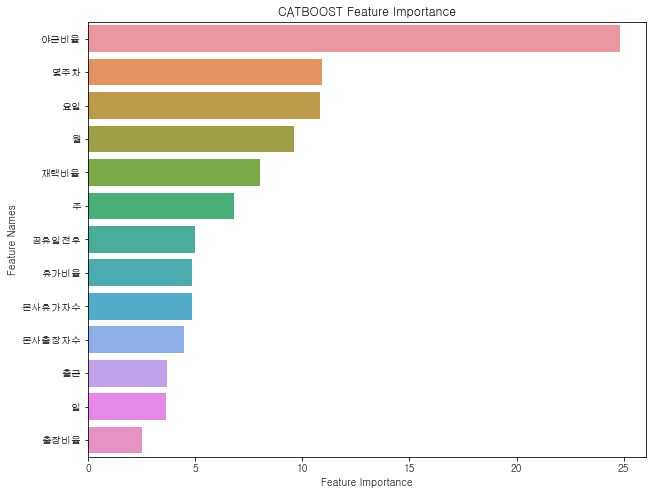

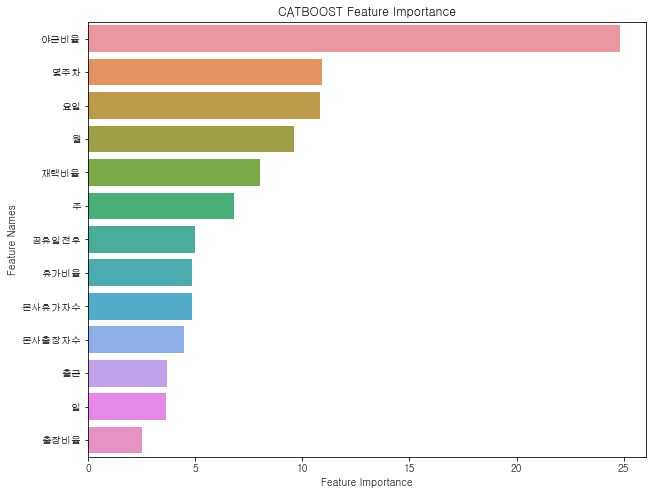

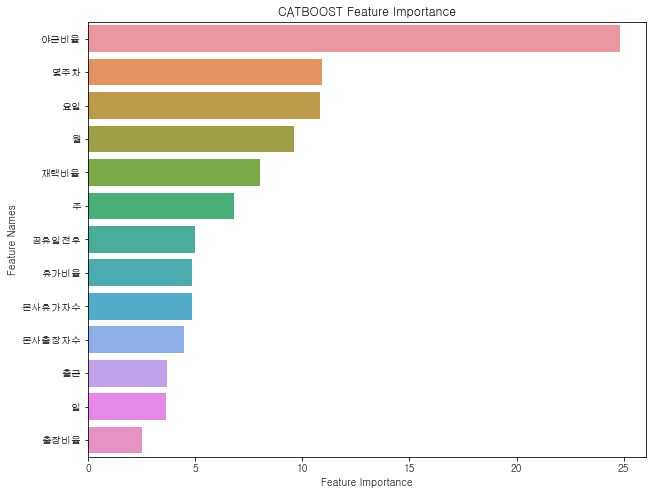

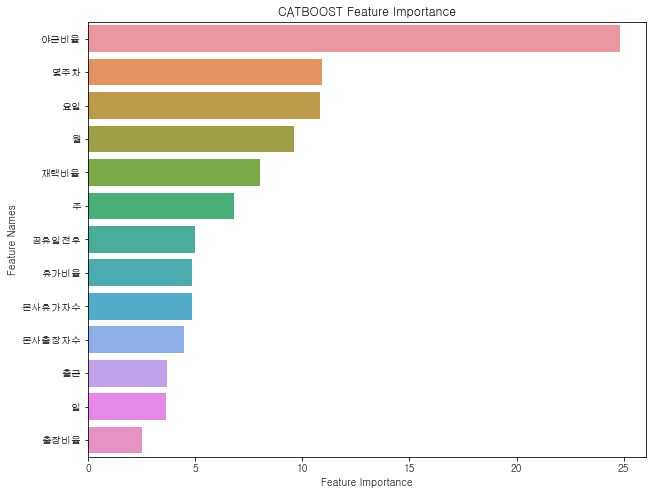

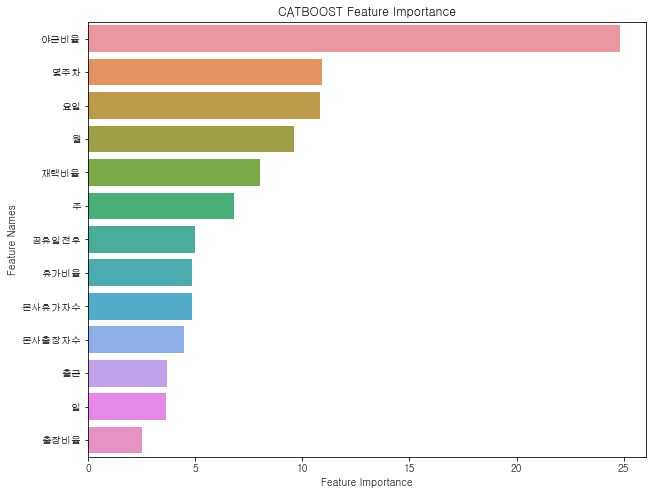

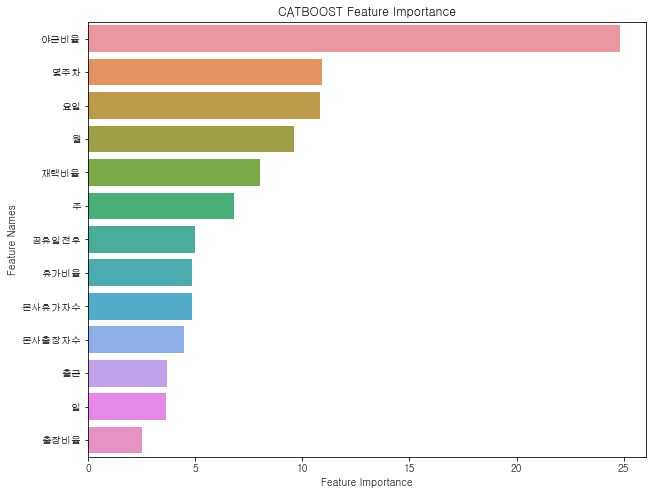

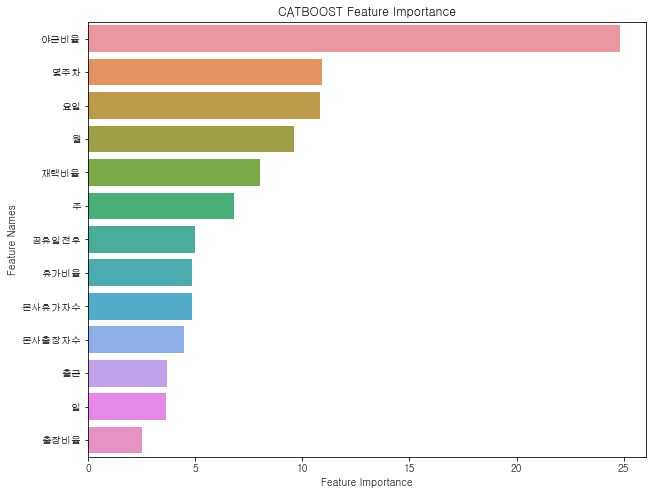

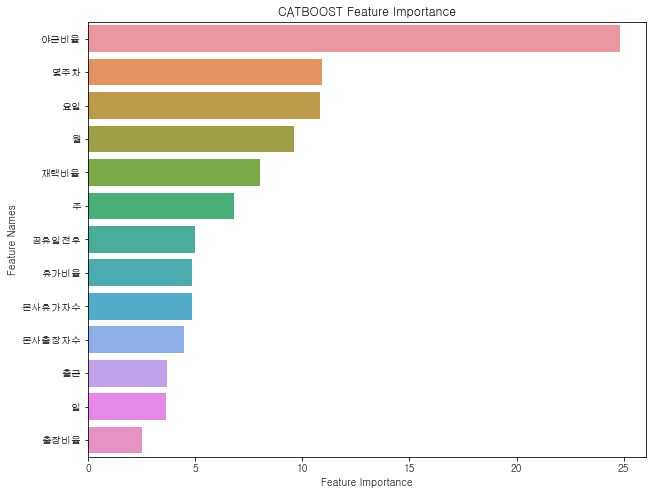

In [23]:
for i in range(n_fold):
    plot_feature_importance(dinner_models[0].get_feature_importance(),dinner_train.iloc[:,:-1].columns,"CATBOOST")